In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import polars as pl
import scipy.io
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np 
from typing import Literal
import torch 
from torch import nn
from transphorm.model_components import AATrialDataModule, TrialClassifer, LSTMClassifer
from dotenv import load_dotenv
import os
load_dotenv()
data_path = Path(os.getenv('TRIAL_DATA_PATH'))
# model_path = "/Users/mds8301/Development/transphorm/models/aa-classifiers/a0383409f8fe4c3683f83cda885528e0/checkpoints/trial_lstm_clf_v2.ckpt"

In [33]:
from transphorm.experiments.aa_classifiers.aa_lstmfcn_bayes_5_day import load_data
X_train, X_test, y_train, y_test = load_data(data_path)


In [34]:
end_idx = 1017*4
X_train = X_train[:,:, :end_idx]
X_test = X_test[:, :, :end_idx]
#caluclate mean across all rows x_train
X_train = X_train.mean(axis=0)
X_train.shape

(1, 4068)

1070.0

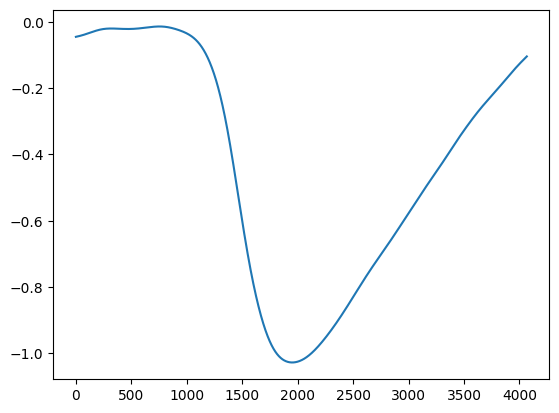

In [36]:
plt.plot(X_train[0])

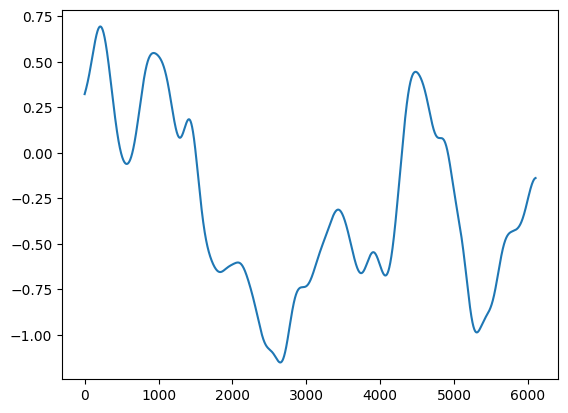

In [11]:
plt.plot(X_train[0][0])

In [13]:
data_mod = AATrialDataModule(data_path)
data_mod.prepare_data()
data_mod.setup('train')

In [14]:
data_mod.test[:][1]

tensor([0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
        0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1.,
        0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1.,
        1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1.,
        0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0.,
        0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 

In [6]:
from torchmetrics import ConfusionMatrix

y_test = data_mod.test[:][1]
num_classes = 2
confmat = ConfusionMatrix(task="binary", num_classes=num_classes)
matrix = confmat(y_test, y_test)
lables = [f"Class_{i}" for i in range(num_classes)]



In [12]:
t1 = torch.rand(10)
t2 = torch.rand(10)
t3 = torch.rand(10)

batch = [t1, t2, t3]
torch.cat(batch)

tensor([0.1246, 0.3118, 0.2487, 0.6336, 0.0091, 0.2708, 0.5037, 0.5449, 0.2742,
        0.6791, 0.1701, 0.0766, 0.4289, 0.2297, 0.8152, 0.1582, 0.4580, 0.7077,
        0.0621, 0.8871, 0.2728, 0.3639, 0.1941, 0.3137, 0.3072, 0.0551, 0.6709,
        0.4984, 0.9891, 0.8373])

In [24]:
h0[-1].shape

torch.Size([32, 8])